# Principal Component Analysis Assignment

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Import the [PitchFX data set](https://docs.google.com/spreadsheets/d/1pmBtSw7v_tU_dIX1-4E8_Q7wC43fDs6LGDQzN49-ffk/export?format=csv).

In [2]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/1pmBtSw7v_tU_dIX1-4E8_Q7wC43fDs6LGDQzN49-ffk/export?format=csv')

In [3]:
# data.info()

### Keep only the pitch type and the numeric columns (exluding ID fields).

* Drop any remaining records that contain null values.
* Consider `pitchType` as `y`/target and the remaining columns to be `X`/features.

In [4]:
numeric = data.select_dtypes(include='number').copy()
numeric['pitchType'] = data['pitchType']
too_many_nulls = (numeric.isnull().sum()/numeric.isnull().count())[lambda x: x>0.8].index
numeric = numeric.drop(too_many_nulls,1)
numeric = numeric.dropna()

In [5]:
numeric = numeric.loc[:, ~numeric.columns.str.contains('Id', case=False)]

In [6]:
numeric['timesFaced'].value_counts()

1    44369
2    17310
3    11235
4      800
0       11
Name: timesFaced, dtype: int64

In [7]:
numeric = numeric[numeric['timesFaced'] != 0]

In [8]:
numeric = numeric.reset_index(drop=True)

### Reduce the dimensionality of the data using PCA to two components.

Don't forget to scale.

In [9]:
X = numeric.drop('pitchType', 1)
y = numeric['pitchType']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
X_scaled

,inning,balls,strikes,outs,timesFaced,probCalledStrike,releaseVelocity,spinRate,spinDir,locationHoriz,locationVert,movementHoriz,movementVert
0,-1.499765,-0.911551,-1.056134,-1.200980,-0.729818,1.170076,0.960488,-0.493761,0.353729,-0.390818,0.715828,-0.959310,0.577148
1,-1.499765,-0.911551,0.160720,-1.200980,-0.729818,0.629435,1.449184,-0.738477,0.592881,0.438200,1.028754,-1.045278,0.400030
2,-1.499765,-0.911551,1.377574,-1.200980,-0.729818,1.153622,1.348074,-0.233181,0.245111,0.492619,-0.003902,-0.692028,0.864726
3,-1.499765,-0.911551,-1.056134,0.027464,-0.729818,1.228842,1.196410,-0.798824,0.243774,0.037585,0.119110,-1.007765,0.600002
4,-1.499765,-0.911551,0.160720,0.027464,-0.729818,1.228842,1.196410,-0.937140,0.354153,0.357151,0.163352,-0.937427,0.784737
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73709,1.532769,0.120965,0.160720,1.255908,-0.729818,1.202985,0.674011,-1.253041,-0.209759,0.185789,0.552891,0.348968,0.704749
73710,1.532769,0.120965,1.377574,1.255908,-0.729818,-1.121773,0.842527,-1.916821,-0.169808,-1.783709,1.404265,0.267689,0.495255
73711,1.532769,1.153481,1.377574,1.255908,-0.729818,1.085454,-0.033756,-4.578540,-0.533199,0.455568,0.725540,0.422431,-0.348435
73712,1.532769,1.153481,1.377574,1.255908,-0.729818,0.819835,0.859378,0.119097,-0.173477,0.696400,-0.261796,0.334900,1.123737


In [10]:
#Just setting n to max (13) so I get a better explained variance curve without repeating code.
#Will use only first 2 components for calculations and visualizations
n = 13

pca = PCA(n_components=n)

X_pca = pd.DataFrame(pca.fit_transform(X_scaled), index=X.index, columns=[f'Component {i}' for i in range(n)])

### Compute the explained variance for new data set.

In [11]:
pca.explained_variance_ratio_[:2].sum()

0.2994373389571944

### Generate a scatter plot that visualizes how the component values are distributed.

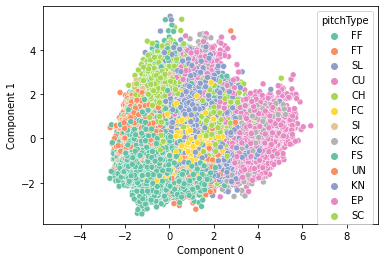

In [12]:
sns.scatterplot(x=X_pca['Component 0'], y=X_pca['Component 1'], hue=y, palette='Set2')
plt.axis('equal')
plt.show()

### Create a line plot that shows the explained variance by number of components.

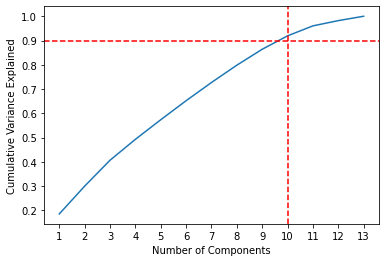

In [28]:
sns.lineplot(x=range(1,X_pca.shape[1]+1), y=np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.9, c='r', ls='--')
plt.axvline(x=10, c='r', ls='--')
plt.ylabel('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.xticks(ticks=range(1,X_pca.shape[1]+1))
plt.show()

### Iteratively train and score a Random Forest Classifier (to predict `pitchType`).

* In each iteration:
    * Increase the number of principal components (start with `2`)
    * Store the number of components and model score

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

pca = PCA(n_components=13)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [15]:
model = RandomForestClassifier(max_depth=4, random_state=1)

In [16]:
rfc_pca_trainscores = {}
rfc_pca_testscores={}

for n in range(2,14):
  model.fit(X_train_pca[:,:n],y_train)
  rfc_pca_trainscores[n] = model.score(X_train_pca[:,:n],y_train)
  rfc_pca_testscores[n] = model.score(X_test_pca[:,:n],y_test)

### Create a line plot that shows the training scores across the different numbers of principal components.

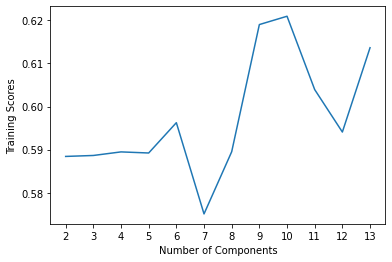

In [17]:
sns.lineplot(x=rfc_pca_trainscores.keys(), y=rfc_pca_trainscores.values())
plt.ylabel('Training Scores')
plt.xlabel('Number of Components')
plt.xticks(ticks=range(2,14))
plt.show()

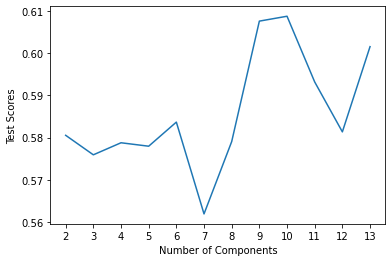

In [18]:
sns.lineplot(x=rfc_pca_testscores.keys(), y=rfc_pca_testscores.values())
plt.ylabel('Test Scores')
plt.xlabel('Number of Components')
plt.xticks(ticks=range(2,14))
plt.show()

### Based on the analysis you conducted, what is the optimal number of principal components?

Based on this analysis, the optimal number of principal components is 10. This is the point where the explained variance is greater than 0.9 and the training score for the RandomForestClassifier is the highest (though the later could be bias of the randomstate and would need to be explored further with a GridSearch).

That being said, that isn't much of a dimensional reduction from the original number of 13. Other methods might be better suited for this data. 